# Model Evaluation

Notebook for comparing the models tested and looking for patterns in performance for different hours of the day.

## Problem Statement

Predict electricity prices in Spain for each hour of the upcoming day more accurately than estimates provided by the Spanish transmission agent and operator. 

Use information available during the 2pm-3pm window the previous day during which generators in Spain submit their bids. 

## Contents

- [Imports](#Imports)
- [Functions Used](#Functions-Used)
- [Prepare Data](#Prepare-Data)
- [High Level Metrics](#High-Level-Metrics)
- [Performance by Hour](#Performance-by-Hour)
    - RMSE
    - R-Squared
- [Distribution of Errors](#Distribution-of-Errors)
- [Best Models](#Best-Models)

### Imports

In [134]:
# General Imports
import pandas as pd
import numpy as np
from sklearn import metrics

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py 
import plotly.graph_objs as go 
import plotly.express as px

In [121]:
# import metrics
nn_metrics = pd.read_csv('../Data/Analysis/nn_metrics.csv')
reg_metrics = pd.read_csv('../Data/Analysis/reg_metrics.csv')
var_metrics = pd.read_csv('../Data/Analysis/var_metrics.csv')

In [122]:
# import predictions
nn_preds = pd.read_csv('../Data/Analysis/nn_predictions.csv')
reg_preds = pd.read_csv('../Data/Analysis/reg_predictions.csv')
var_preds = pd.read_csv('../Data/Analysis/var_predictions.csv')

### Functions Used

### Prepare Data

Both sets of data frames need to be joined with their respective pairs and further the metrics data frames need to have the 'unnamed: 0' column droped and their index set to 'hour x'. The prediction data frames need to have the time columns converted to being a datetime index.

In [123]:
# Drop unamed: 0
nn_metrics.drop(columns=['Unnamed: 0'], inplace = True)
reg_metrics.drop(columns=['Unnamed: 0'], inplace = True)
var_metrics.drop(columns=['Unnamed: 0'], inplace = True)

In [124]:
# Create metrics df
metrics_df = pd.concat([reg_metrics, nn_metrics, var_metrics],
                        axis=1, sort=False)
metrics_df.head(2)

,lin_reg_test_rmse,lin_reg_train_r2,lin_reg_test_r2,e_net_test_rmse,e_net_train_r2,e_net_test_r2,knn_test_rmse,knn_train_r2,knn_test_r2,rf_test_rmse,...,rnn_train_r2,rnn_test_r2,cnn_test_rmse,cnn_train_r2,cnn_test_r2,lstm_test_rmse,lstm_train_r2,lstm_test_r2,var_test_rmse,var_test_r2
0,5.748025,0.837470,0.714437,5.772251,0.836942,0.712025,7.165323,0.761384,0.556252,6.482274,...,0.787346,0.356110,6.463941,0.759154,0.638873,8.954309,0.541226,0.307007,3.591614,0.888508
1,6.103116,0.825918,0.717623,6.119451,0.825228,0.716109,7.893097,0.748584,0.527696,7.369454,...,0.791448,0.335318,7.165871,0.735592,0.610718,9.725503,0.518984,0.282948,4.170260,0.868158


In [125]:
# create hour column
metrics_df['hour'] = [i for i in range(0,24)]
metrics_df.head(2)

,lin_reg_test_rmse,lin_reg_train_r2,lin_reg_test_r2,e_net_test_rmse,e_net_train_r2,e_net_test_r2,knn_test_rmse,knn_train_r2,knn_test_r2,rf_test_rmse,...,rnn_test_r2,cnn_test_rmse,cnn_train_r2,cnn_test_r2,lstm_test_rmse,lstm_train_r2,lstm_test_r2,var_test_rmse,var_test_r2,hour
0,5.748025,0.837470,0.714437,5.772251,0.836942,0.712025,7.165323,0.761384,0.556252,6.482274,...,0.356110,6.463941,0.759154,0.638873,8.954309,0.541226,0.307007,3.591614,0.888508,0
1,6.103116,0.825918,0.717623,6.119451,0.825228,0.716109,7.893097,0.748584,0.527696,7.369454,...,0.335318,7.165871,0.735592,0.610718,9.725503,0.518984,0.282948,4.170260,0.868158,1


Metrics dataframe is ready for analysis.

In [126]:
# clean predictions dfs
# set index as time
nn_preds.set_index(pd.DatetimeIndex(nn_preds['time']), inplace=True)
reg_preds.set_index(pd.DatetimeIndex(reg_preds['time']), inplace=True)
var_preds.set_index(pd.DatetimeIndex(var_preds['time']), inplace=True)
# Drop time column
nn_preds.drop(columns=['time'], inplace=True)
reg_preds.drop(columns=['time'], inplace=True)
var_preds.drop(columns=['time'], inplace=True)
# sort index
nn_preds.sort_index(inplace=True)
reg_preds.sort_index(inplace=True)
var_preds.sort_index(inplace=True)

In [127]:
# Create predictions df
predictions_df = pd.concat([reg_preds, nn_preds[['cnn','lstm']], var_preds[['var']]],
                        axis=1, sort=False)
predictions_df.head(2)

,price_actual,price_day_ahead,lin_reg,e_net,knn,rf,ada,svr,cnn,lstm,var
time,,,,,,,,,,,
2018-01-01 00:00:00+00:00,20.76,6.74,31.770592,30.864549,30.864549,35.2893,38.492384,29.132312,40.298073,44.006966,16.053193
2018-01-01 01:00:00+00:00,19.02,4.74,30.554279,28.474588,28.474588,31.3505,30.774154,28.383815,37.405537,41.352783,11.111584


Now our 2 analysis data frames are ready.

### High Level Metrics

First let's look at over the high level metrics for each of model types, rmse & r-squared to refresh our view on which were best.

In [128]:
# First get rmse and test r2 columns from the metrics
rmse_cols = [col for col in metrics_df.columns if col.endswith('rmse')]
r2_cols = [col for col in metrics_df.columns if col.endswith('test_r2')]

In [129]:
metrics_df[rmse_cols].describe().T.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
var_test_rmse,24.0,5.575370,0.929462,3.591614,5.098437,5.706196,6.413745,6.684455
svr_test_rmse,24.0,5.861017,0.347601,5.380480,5.565653,5.916765,6.092138,6.528117
e_net_test_rmse,24.0,5.942493,0.400009,5.368821,5.615814,5.918572,6.140093,6.767992
lin_reg_test_rmse,24.0,5.978276,0.405687,5.402746,5.659744,5.906032,6.190153,6.826170
cnn_test_rmse,24.0,6.414636,0.497576,5.551649,6.054459,6.451337,6.791788,7.212440
rf_test_rmse,24.0,6.892890,0.865281,5.520268,6.118850,6.911735,7.399846,8.491909
ada_test_rmse,24.0,7.119702,0.729551,5.683866,6.432974,7.259775,7.732652,8.080586
knn_test_rmse,24.0,7.472363,0.698402,5.993699,6.928633,7.612452,8.018745,8.487968
rnn_test_rmse,24.0,7.813295,0.724297,6.299555,7.179868,7.936063,8.239226,8.983103
lstm_test_rmse,24.0,9.201877,0.971797,7.198084,8.578903,9.311308,9.999684,10.757533


In [132]:
metrics_df[r2_cols].describe().T.sort_values('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
var_test_r2,24.0,0.729843,0.109217,0.537102,0.695741,0.727999,0.819664,0.888508
svr_test_r2,24.0,0.712508,0.064067,0.564932,0.703917,0.732584,0.748760,0.797224
e_net_test_r2,24.0,0.702700,0.076778,0.526648,0.700070,0.723849,0.747140,0.801361
lin_reg_test_r2,24.0,0.698824,0.079239,0.517575,0.694516,0.721589,0.744032,0.798843
cnn_test_r2,24.0,0.658081,0.067174,0.473562,0.626033,0.680035,0.711517,0.729775
rf_test_r2,24.0,0.609870,0.066824,0.496458,0.564644,0.621383,0.662448,0.707163
ada_test_r2,24.0,0.579495,0.095926,0.224895,0.565427,0.586845,0.638845,0.671181
knn_test_r2,24.0,0.542787,0.046053,0.445879,0.511994,0.541510,0.574639,0.616905
rnn_test_r2,24.0,0.456544,0.091274,0.315334,0.353073,0.490102,0.533040,0.566119
lstm_test_r2,24.0,0.308769,0.064115,0.202498,0.259935,0.302787,0.362163,0.403073


From these high level metrics it is clear that the VAR, SVR, Elatic Net and Linear regression have performed the best on aggregate. 

In particular the VAR and SVR are the two highest for each score. Interestingly, the SVR seems to perform more steadily with the difference between it's highest and lowest hour scores for for rmse being 1.15 euros vs 3.09 euros for the VAR model. We will have to take a closer look at their performance but it seems as though SVR may be a superior model despite worse mean scores.

Now let's take the predictions dataframe and calculate rmse and r-squared across all predictions.

In [137]:
# loop through columns and calculated rmse & R-sqaured
# create dictionary for saving values and actual price for calculation
full_metrics = {}
y = predictions_df['price_actual']
# loop through prediction columns and append stats to dictionary
for col in predictions_df.columns[2:]:
    # get predictions
    y_pred = predictions_df[col]
    # Create nested dictionary for each col
    full_metrics[col] = {}
    # get scores
    full_metrics[col]['test_rmse'] = np.sqrt(((y-y_pred)**(2)).mean())
    full_metrics[col]['test_r2'] =  metrics.r2_score(y, y_pred)
    
full_metrics

{'lin_reg': {'test_rmse': 5.9914526797974235, 'test_r2': 0.7594743769532359},
 'e_net': {'test_rmse': 5.955381150582516, 'test_r2': 0.7623618268582802},
 'knn': {'test_rmse': 5.955381150582516, 'test_r2': 0.7623618268582802},
 'rf': {'test_rmse': 6.920280337684754, 'test_r2': 0.6791186642463167},
 'ada': {'test_rmse': 7.1554332976311334, 'test_r2': 0.6569408902496745},
 'svr': {'test_rmse': 5.87088681025975, 'test_r2': 0.7690571634611693},
 'cnn': {'test_rmse': 6.433103097297204, 'test_r2': 0.7227075122939357},
 'lstm': {'test_rmse': 9.250923500901887, 'test_r2': 0.426587362314767},
 'var': {'test_rmse': 5.649128225988768, 'test_r2': 0.7861742784174158}}

In [138]:
full_metrics_df = pd.DataFrame(full_metrics)
full_metrics_df

,lin_reg,e_net,knn,rf,ada,svr,cnn,lstm,var
test_rmse,5.991453,5.955381,5.955381,6.920280,7.155433,5.870887,6.433103,9.250924,5.649128
test_r2,0.759474,0.762362,0.762362,0.679119,0.656941,0.769057,0.722708,0.426587,0.786174


Going by the full values we see similar results with the same 4 model types performing the best. However, calculating for the full set of values does improve our r-squared scores which is a nice bonus.

Overall it looks as though the VAR and SVR models are the best 2 but in future iterations it seems worth it to include the elastic net and cnn models to see if they become the best models as we look to increase / improve the features we are using.

There is also a caveat with the VAR model in that we retrained the model at each time step when generating predictions and thus it is not a 1 to 1 comparison with the other model types that were only trained on the train data.

Let's take a look at performance by hour now.

### Performance by Hour

This problem is somewhat peculiar because we are predicting 24 hours of future data at the same time. Thus we want to look at how our models did at predicting different hours and whether there are certain hours that were 'easier' to predict than others.

In [23]:
# First get rmse and test r2 columns from the metrics
rmse_cols = [col for col in metrics_df.columns if col.endswith('rmse')]
r2_cols = [col for col in metrics_df.columns if col.endswith('test_r2')]

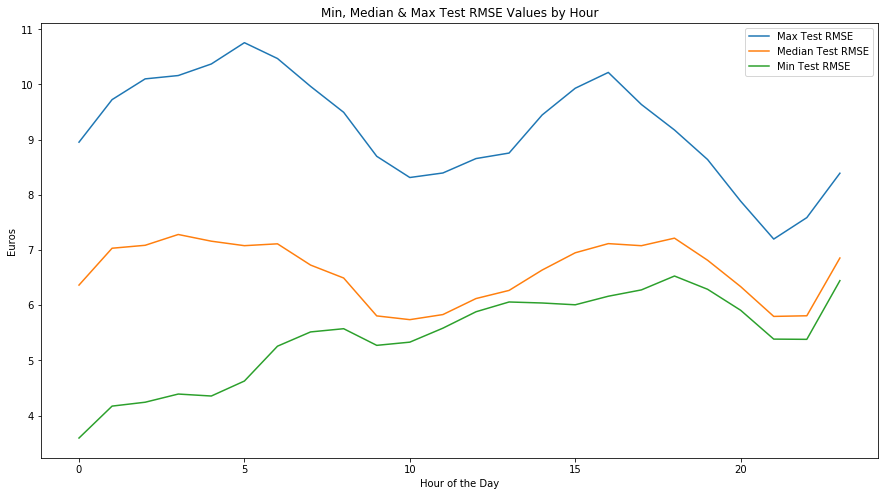

In [42]:
# plot min, median, max rmse by hour
plt.figure(figsize=(15,8))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].max(axis=1))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].median(axis=1))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].min(axis=1))
plt.legend(['Max Test RMSE', 'Median Test RMSE', 'Min Test RMSE'])
plt.title('Min, Median & Max Test RMSE Values by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Euros');

From this plot it looks as though the models on aggregate are generally best at predicting mid-morning and late evening times. This is somewhat unexpected, especially for the late evening, as we are closer to the morning and intuitively would expect that those predictions that aren't as far ahead in time would be more accurate. If we look at the minimum though we see that sort of trend where predictions get worse over time.

Additionally, at first glance, it appears as though we are being most accurate during the times when electric prices are highest, when we might expect that our RMSE would go up when prices are highest.

Let's look at the same plot but with electric prices plotted on a second axis so that we can see how they compare.

In [45]:
# add hour column to predictions df so we can groupby and get median price
predictions_df['hour'] = predictions_df.index.hour

In [47]:
# get median price by hour
metrics_df['median_price'] = predictions_df.groupby('hour')['price_actual'].median()

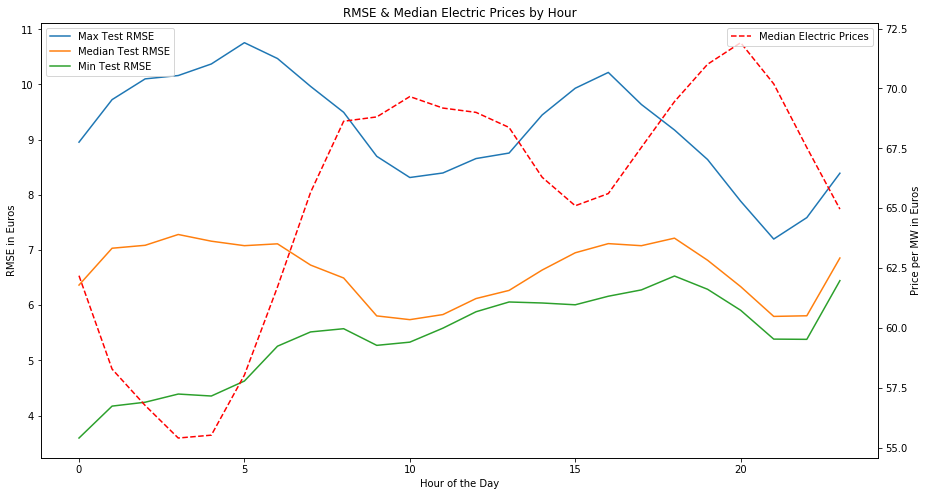

In [74]:
# plot rmse & median price
# thanks webDev for help w/secondary axis
# https://stackoverflow.com/questions/55654500/seaborn-plot-with-second-y-axis
# Thanks DavidG for help with dashed line
# https://stackoverflow.com/questions/51963725/how-to-plot-a-dashed-line-on-seaborn-lineplot
fig, ax1 = plt.subplots(figsize=(15,8))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].max(axis=1),
             ax=ax1)
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].median(axis=1),
             ax=ax1)
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[rmse_cols].min(axis=1),
             ax=ax1)
ax1.legend(['Max Test RMSE', 'Median Test RMSE', 'Min Test RMSE'], loc='upper left')
# secondary axis
ax2 = plt.twinx()
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['median_price'],
             ax=ax2,
             color='red')
ax2.lines[0].set_linestyle("--")
plt.title('RMSE & Median Electric Prices by Hour')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('RMSE in Euros')
ax2.set_ylabel('Price per MW in Euros')
ax2.legend(['Median Electric Prices'], loc='upper right');

From this graph we can clearly see that median RMSE seems to have somewhat inverse relationship with electric prices. While it would take more in depth analysis to figure out exactly why this is the case, it is certainly interesting.

Let's take a look at the min, median and max test r2 values to get a better sense of how we are doing at each hour.

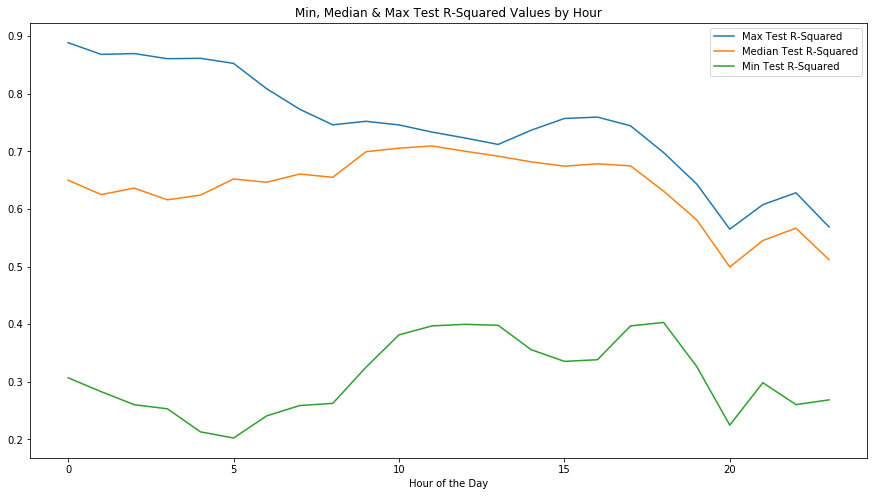

In [43]:
# plot min, median, max r2 by hour
plt.figure(figsize=(15,8))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[r2_cols].max(axis=1))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[r2_cols].median(axis=1))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df[r2_cols].min(axis=1))
plt.legend(['Max Test R-Squared', 'Median Test R-Squared', 'Min Test R-Squared'])
plt.title('Min, Median & Max Test R-Squared Values by Hour')
plt.xlabel('Hour of the Day');

When looking at R-squared, especially the max values, we see more of the trend we would expect, in which our predictions are explaining less and less of the variance in the electric price as time goes on.  

Now that we have a good understanding of how our data behaved in general let's take a look at which models performed best at different hours and also look at the RMSE & r-squared values for our best performing models.

In [100]:
# Thanks Scott Rosenthal for help getting minimum column index
# Top performing model by hour (rmse)
best_models_rmse = [rmse_cols[i] for i in np.argmin(metrics_df[rmse_cols].values, axis =1)]

In [101]:
# get for r-2 as well
best_models_r2 = [r2_cols[i] for i in np.argmax(metrics_df[r2_cols].values, axis =1)]

In [104]:
# create dataframe of best models
best_models = pd.DataFrame([best_models_rmse,best_models_r2],
                          columns=['hour '+str(i) for i in range(0,24)]).T
best_models.columns = ['Best RMSE', 'Best R-Squared']

In [105]:
best_models

,Best RMSE,Best R-Squared
hour 0,var_test_rmse,var_test_r2
hour 1,var_test_rmse,var_test_r2
hour 2,var_test_rmse,var_test_r2
hour 3,var_test_rmse,var_test_r2
hour 4,var_test_rmse,var_test_r2
hour 5,var_test_rmse,var_test_r2
hour 6,var_test_rmse,var_test_r2
hour 7,svr_test_rmse,svr_test_r2
hour 8,e_net_test_rmse,e_net_test_r2
hour 9,var_test_rmse,var_test_r2


In [139]:
best_models['Best RMSE'].value_counts()

svr_test_rmse      12
var_test_rmse      10
cnn_test_rmse       1
e_net_test_rmse     1
Name: Best RMSE, dtype: int64

VAR and SVR have an overwhelming number of 'bests' here which matches up with their scores being the best. SVR has 12 best values in each and VAR has 10. 

Intestingly SVR seems to do better later in the day while VAR did best early in the day. It was also nice to see that cnn and elatic net each had one 'best' hour and validates the idea of incorporating them in furture iterations.

Let's plot the rmse and r-squared values for each of these models to get a visual look.

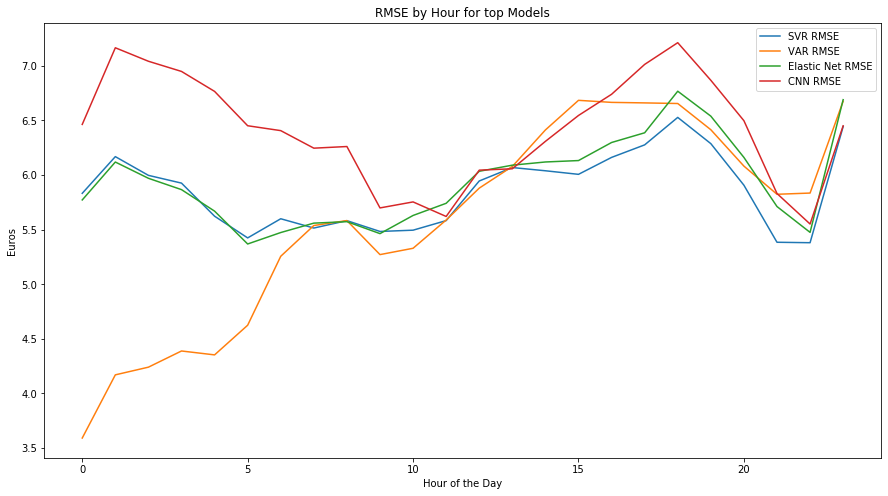

In [140]:
# plot rmse by hour for top models
plt.figure(figsize=(15,8))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['svr_test_rmse'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['var_test_rmse'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['e_net_test_rmse'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['cnn_test_rmse'])
plt.legend(['SVR RMSE', 'VAR RMSE', 'Elastic Net RMSE', 'CNN RMSE'])
plt.title('RMSE by Hour for top Models')
plt.ylabel('Euros')
plt.xlabel('Hour of the Day');

This plot shows more clearly what we are seeing above. Specifically the VAR model does extremely well early in the day but it's performance gets progressively worse. Meanwhile the SVR and Elastic Net models perform much more steadily throughout the day. 

Looking at this perhaps the best model would be using a VAR to predict the prices until noon and the SVR to predict prices afterwards.

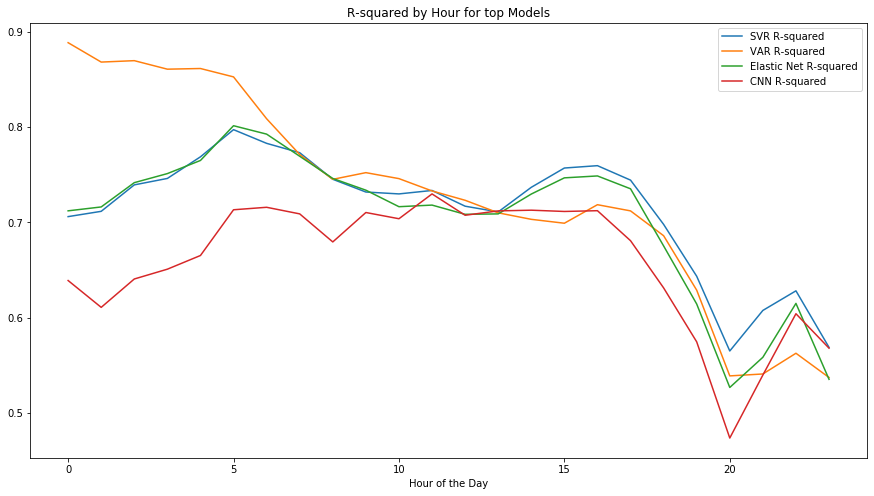

In [142]:
# plot r-square by hour for top models
plt.figure(figsize=(15,8))
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['svr_test_r2'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['var_test_r2'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['e_net_test_r2'])
sns.lineplot(x = metrics_df['hour'],
             y = metrics_df['cnn_test_r2'])
plt.legend(['SVR R-squared', 'VAR R-squared', 'Elastic Net R-squared', 'CNN R-squared'])
plt.title('R-squared by Hour for top Models')
plt.ylabel(None)
plt.xlabel('Hour of the Day');

### Distribution of Errors

### Best Models